In [22]:
import re
import matplotlib.pyplot as plt


def read_log_file(path):
    with open(path, "r") as file:
        log_lines = file.readlines()
    return log_lines


def extract_data(log_lines, pattern):
    results = []
    for line in log_lines:
        match = re.match(pattern, line)
        if match:
            results.append(match.group(1))
    return results

In [43]:
def plot_pre_gen_loss(log_lines):
    pattern = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3} - )?(\d+)/\d+: loss = (\d+\.\d+), PSNR = (\d+\.\d+)"
    results = [[],[],[]]

    for line in log_lines:
        match = re.match(pattern, line)
        if match:
            results[0].append(int(match.group(2)))
            results[1].append(float(match.group(3)))
            results[2].append(float(match.group(4)))
    print(results)
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    par = ax.twinx()
    ax.plot(results[0], results[1], color='blue', label='Loss')
    par.plot(results[0], results[2], color='red', label='PSNR')
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    par.set_ylabel('PSNR')
    ax.legend(loc='upper left')
    par.legend(loc='upper right')
    ax.set_title("Loss and PSNR Over Training Steps")

    return fig  

[[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000], [339.376, 201.376, 131.376, 121.27, 110.066, 103.504, 98.313, 94.765, 92.602, 89.243], [24.065774, 26.54574, 29.094074, 30.013708, 30.377758, 31.352081, 31.682825, 30.721531, 31.190556, 32.36055]]


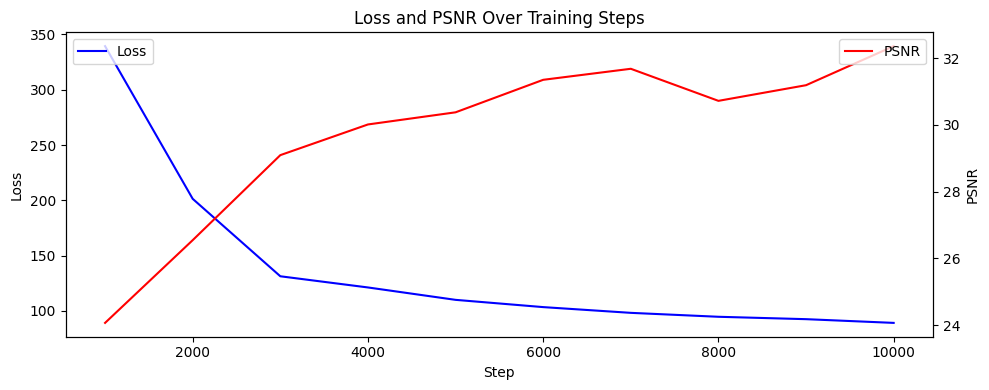

In [41]:
log_file = 'results/training_x2.log'
log_lines = read_log_file(log_file)
fig = plot_pre_gen_loss(log_lines)
plt.tight_layout()
fig.savefig('results/training/pre_gen_loss_x2.png')

[[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000], [470.77, 243.433, 208.984, 188.955, 180.453, 171.508, 167.156, 162.67, 160.239, 155.443], [25.698721, 26.805218, 27.235611, 28.056026, 27.990301, 28.405476, 28.469427, 28.940228, 29.302181, 29.1117]]


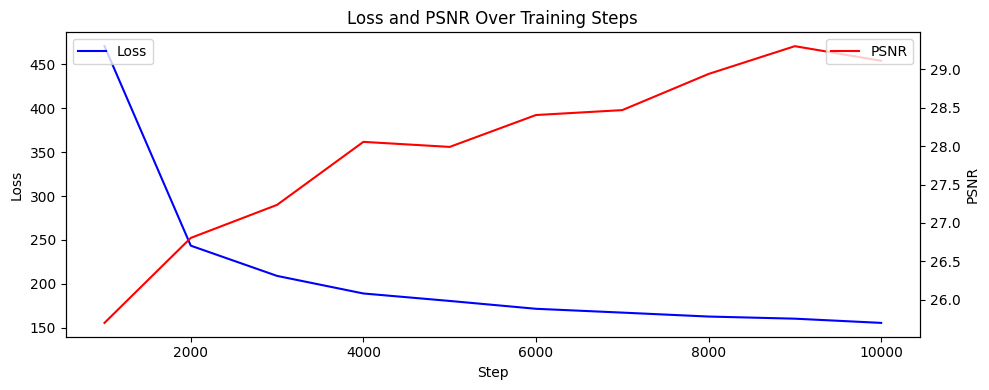

In [44]:
log_file = 'results/training_x3.log'
log_lines = read_log_file(log_file)
fig = plot_pre_gen_loss(log_lines)
plt.tight_layout()
fig.savefig('results/training/pre_gen_loss_x3.png')

[[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000], [554.476, 307.166, 264.787, 246.627, 235.714, 225.591, 220.434, 216.592, 210.747, 208.809], [25.087826, 25.265505, 26.383556, 26.790842, 27.383297, 27.14654, 27.410046, 27.707214, 27.353745, 27.665134]]


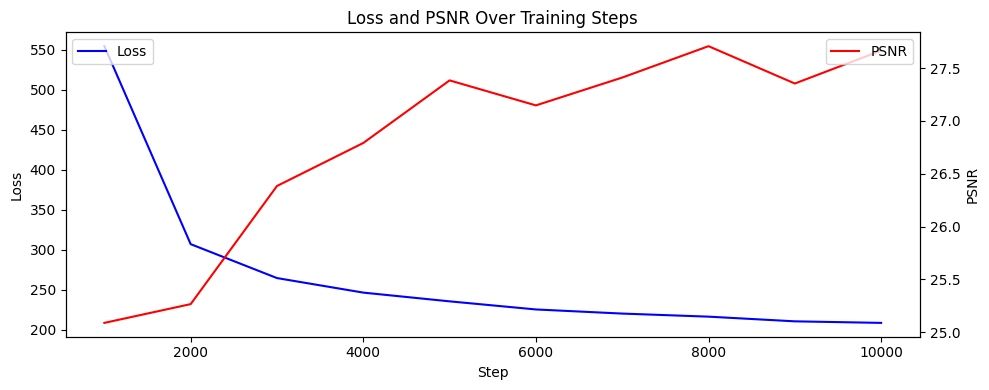

In [45]:
log_file = 'results/training_x4.log'
log_lines = read_log_file(log_file)
fig = plot_pre_gen_loss(log_lines)
plt.tight_layout()
fig.savefig('results/training/pre_gen_loss_x4.png')